In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from time import gmtime, strftime
from datetime import datetime
from datetime import timedelta

In [5]:
def csv_read(fidPath,idNum):
    df = pd.read_csv(fidPath,header = None, sep = ',')
    # Convert the format of date
    dates = df[0]
    df.index = pd.to_datetime(dates.astype(str), format='%Y%m%d%H%M%S')
    df.index.name = 'Date'
    del df[0] # Remove the "Date" column
    
    
    endNum = len(df.columns)
    #print("endNum:" + str(endNum))
    for ii in range(2,endNum):        
        del df[ii]   
    
    
    # Creat an empty dataframe
    _df = pd.DataFrame({df.columns[0] :[int(idNum)],
                        df.columns[-1]:[np.nan]})
    _df.index.name = 'Date'

    countNum = 0
    startIndexNum = 0
    threshold = timedelta(minutes = 15)
    
    while True:
        try:
            for ii in range(startIndexNum, len(df)):
                dt  = df.index[ii+1]-df.index[ii]        
                if (dt > threshold):
                    # Put the row of NaN values into dataframe
                    _dt = df.index[ii]-df.index[ii-1]
                    _timestamp = df.index[ii] + _dt
                    _df.index = [pd.to_datetime(_timestamp)] # Creat a list for containing a timestamp!!
                    df = df.append(_df)
                    df = df.sort_index()
                    startIndexNum = ii + 1
                    #print("countNum: ", countNum)
                    #print("startIndexNum: ", startIndexNum)
                    countNum += 1
                    break
        except:
                print("ID numeber {} is done!".format(idNum))
                break
    
    return df

def creatURL(idN, t):
    string = "http://ec2-54-175-179-28.compute-1.amazonaws.com/get_thinktron_data.php?device_id={}&year_month={}".format(idN,t)
    return string    

def query_data(arg1):
    r = requests.get(arg1) # URL path
    soup = BeautifulSoup(r.text,'lxml')
    a = list(soup.find_all('p'))

    # Split the list through the regular expression
    d = re.split('\s+|,|<br/>|<p>|</p>',str(a))

    # Remove the '' element from the list
    d = list(filter(lambda zz: zz != '', d)) 

    # Remove the '=' element from the list
    d = list(filter(lambda zz: zz != '=', d))

    # Remove the '[' & ']' element from the list
    try:
        d.remove(']')
        d.remove('[')
    except:
        pass
    
    return d

def creat_df(d):
# Create a dataframe from the URL by data crawling
    colName=['id', 'time', 'roll', 'pitch', 'yaw','field1','field2','field3']
    _Num = 0
    _df  = pd.DataFrame(columns=colName)
    df   = pd.DataFrame(columns=colName)

    for ii in range(0,len(d)):    
        while colName[_Num] in d[ii]:
            _lst = d[ii + 1]
            _lst = _lst.strip(',')

            if _lst == '' or (_lst in colName):
                _lst = None       

            _df[colName[_Num]] = [_lst] # Put the list into the dataframe
            if _Num < (len(colName)-1):
                _Num += 1
            else:
                df = df.append(_df, ignore_index=True)
                _Num = 0
    # Convert argument to a numeric type(float64 or int64)
    numericCol = ['roll', 'pitch', 'yaw','field1','field2','field3']
    for ii in numericCol:
        df[ii] = pd.to_numeric(df[ii])

    # Convert the format of date
    import datetime
    dates = df.time
    df.index = pd.to_datetime(dates.astype(str), format='%Y%m%d%H%M%S')
    df.index.name = 'time'
    del df['time']
    
    return df

def setTimetRange(sT,df,deltaDay):
    sT = pd.to_datetime(sT, format='%Y%m%d%H%M%S')
    
    if (deltaDay == 0):
        dfArr = df.loc[sT:]
    else:
        sE = sT + timedelta(days = deltaDay)
        dfArr = df.loc[sT:sE]
    
    print(dfArr.head())
    print("-----------------------------")
    print(dfArr.tail())
    print("-----------------------------")
    return dfArr

def insertNONE(dfPlot, idVal):
    threshold = timedelta(minutes = 13)
    # Creat an empty dataframe 
    _df = pd.DataFrame({"id":[idVal],
                        "roll":[np.nan],
                        "pitch":[np.nan],
                        "yaw":[np.nan],
                        "field1":[np.nan],
                        "field2":[np.nan],
                        "field3":[np.nan]})
    _df.index.name = 'time'
    #print(_df)

    countNum = 0
    startIndexNum = 0
    while True:
        try:
            for ii in range(startIndexNum, len(dfPlot)):
                dt  = dfPlot.index[ii+1]-dfPlot.index[ii]        
                if (dt > threshold):
                    # Put the row of NaN values into dataframe
                    _dt = dfPlot.index[ii]-dfPlot.index[ii-1]
                    _timestamp = dfPlot.index[ii] + _dt
                    _df.index = [pd.to_datetime(_timestamp)] # Creat a list for containing a timestamp!!
                    dfPlot = dfPlot.append(_df)
                    dfPlot = dfPlot.sort_index()
                    startIndexNum = ii + 1
                    #print("countNum: ", countNum)
                    #print("startIndexNum: ", startIndexNum)
                    countNum += 1
                    break
        except:
                
                print("Device ID: {}".format(idVal))
                print("Inserting NONE valus is done.")
                print("We have {} NONE value.".format(countNum))
                print("-----------------------------")
                break
     
    # Return a boolean same-sized object indicating if the values are NONE.
    dfPlot  = dfPlot[dfPlot.columns[-1]].isna()
    return dfPlot

def plotSingleDia(inputDF, idVal):
    fig = plt.figure(num=1, figsize=[12,5])
    ax1 = plt.subplot(111)
    plt.grid()
    ax1.set_title(str(idVal) +'.Online/Offline', fontdict = {'fontsize':14})
    for ii in range(0,len(inputDF)):
        if inputDF[ii]:
            #print("It is a NAN value.")
            plt.scatter(inputDF.index[ii],0, c ='b', marker='o', s = 1.5)
        else:
            #print("It is not a NAN value.")
            plt.scatter(inputDF.index[ii],1, c ='b', marker='o', s = 1.5)       

    packetLossRate = inputDF.sum()/inputDF.count()
    packetLossRate = round(packetLossRate,4) * 100
    
    dt = inputDF.index[-1] - inputDF.index[0]
    dt_hours = dt.days*24 + dt.seconds//3600 # Unit in hr
    #dt_hours = 310
    ax1.text(inputDF.index[40] - timedelta(days = 0.025),1.55,
             "Packet loss rate: {:.3} %\n".format(packetLossRate) +
             "Operating time: {} hr".format(dt_hours),
             fontsize = 12, 
             bbox = dict(facecolor="white", alpha = 1, edgecolor = "none" ))

    plt.ylim(-1.1, 2.1)
    plt.yticks(np.arange(2), ('Offline', 'Online'), fontsize = 14)

    ax1.set_xlim(inputDF.index[0] - timedelta(days = 0.05), inputDF.index[-1] + timedelta(days = 0.05))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    plt.xticks(rotation = 30)
    minorLocator = MultipleLocator(0.5)
    ax1.xaxis.set_minor_locator(minorLocator)
    

    now = strftime("%Y%m%d%H%M%S")
    fig.savefig('packetLoss_ana_' + str(idVal) + '_' + now +'.jpg', dpi= 400)


YYYYMM = 201911
YYYYMM = 201912
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5717 entries, 2019-11-08 14:02:28 to 2019-12-31 23:51:38
Data columns (total 7 columns):
id        5717 non-null object
roll      5717 non-null float64
pitch     5717 non-null float64
yaw       5717 non-null object
field1    5717 non-null object
field2    5717 non-null object
field3    5717 non-null object
dtypes: float64(2), object(5)
memory usage: 357.3+ KB
Device ID: 5001
Inserting NONE valus is done.
We have 1778 NONE value.
-----------------------------
2019-11-08 14:02:28    False
2019-11-08 14:12:55    False
2019-11-08 14:23:14    False
2019-11-08 14:33:33    False
2019-11-08 14:43:51    False
Name: field3, dtype: bool
-----------------------------
2019-12-31 23:10:23    False
2019-12-31 23:20:42    False
2019-12-31 23:31:00    False
2019-12-31 23:41:19    False
2019-12-31 23:51:38    False
Name: field3, dtype: bool
-----------------------------


'\nidNum = 5001\nqueryURL = creatURL(idNum, 201912)\nqueryStr = query_data(queryURL)\nqueryDf  = creat_df(queryStr)\n\nif queryDf.empty:\n    print("No data")\nelse:\n    dfPlot1  = insertNONE(queryDf, idNum)\n    dfPlot1  = setTimetRange(\'20191201000000\', dfPlot1, 0)\n    plotSingleDia(dfPlot1, idNum)\n'

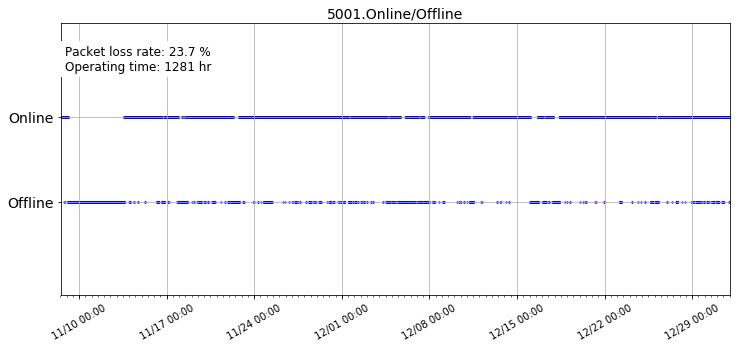

In [6]:
idNum = '5001'
colName=['id', 'time', 'roll', 'pitch', 'yaw','field1','field2','field3']
queryDf_merge = pd.DataFrame(columns=colName)

YYYYMM = ['201911','201912']
for ii in YYYYMM:
    print("YYYYMM = {}".format(ii))
    queryURL = creatURL(idNum, ii)
    queryStr = query_data(queryURL)
    queryDf  = creat_df(queryStr)
    queryDf_merge = queryDf_merge.append(queryDf, sort = False)

del queryDf_merge['time']
queryDf_merge.info()
#dfPlot = insertNONEval(queryDf_merge, idNum)

dfPlot1  = insertNONE(queryDf_merge, idNum)
dfPlot1  = setTimetRange('20191101000000', dfPlot1, 0)
plotSingleDia(dfPlot1, idNum)


'''
idNum = 5001
queryURL = creatURL(idNum, 201912)
queryStr = query_data(queryURL)
queryDf  = creat_df(queryStr)

if queryDf.empty:
    print("No data")
else:
    dfPlot1  = insertNONE(queryDf, idNum)
    dfPlot1  = setTimetRange('20191201000000', dfPlot1, 0)
    plotSingleDia(dfPlot1, idNum)
'''

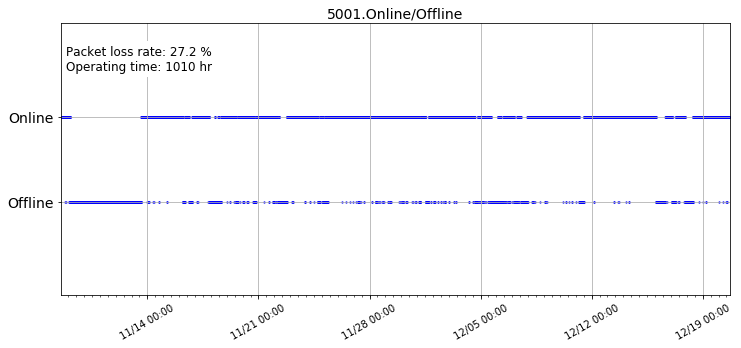

In [4]:
plotSingleDia(dfPlot1, idNum)

Device ID: 5003
Inserting NONE valus is done.
We have 546 NONE value.
-----------------------------
2019-11-01 17:36:39    False
2019-11-01 17:46:48    False
2019-11-01 17:57:08    False
2019-11-01 18:07:28    False
2019-11-01 18:17:49    False
Name: field3, dtype: bool
-----------------------------
2019-11-17 16:50:11    True
2019-11-17 17:00:19    True
2019-11-17 17:10:27    True
2019-11-17 17:20:35    True
2019-11-17 17:30:43    True
Name: field3, dtype: bool
-----------------------------


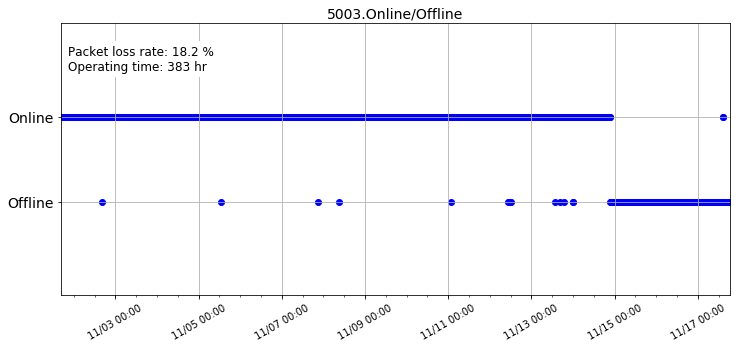

In [17]:
idNum = 5003
queryURL = creatURL(idNum, 201911)
queryStr = query_data(queryURL)
queryDf  = creat_df(queryStr)
dfPlot1  = insertNONE(queryDf, idNum)
dfPlot1  = setTimetRange('20191101173639', dfPlot1, 16)
plotSingleDia(dfPlot1, idNum)

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dfPlot1)
    print(dfPlot1.info())

2019-11-08 14:02:28    False
2019-11-08 14:12:55    False
2019-11-08 14:23:14    False
2019-11-08 14:33:33    False
2019-11-08 14:43:51    False
2019-11-08 14:54:10    False
2019-11-08 15:04:27    False
2019-11-08 15:14:44    False
2019-11-08 15:25:01    False
2019-11-08 15:35:18    False
2019-11-08 15:45:35    False
2019-11-08 15:55:51    False
2019-11-08 16:06:07    False
2019-11-08 16:16:23    False
2019-11-08 16:26:38    False
2019-11-08 16:36:54    False
2019-11-08 16:47:09    False
2019-11-08 16:57:25    False
2019-11-08 17:07:40    False
2019-11-08 17:17:55    False
2019-11-08 17:28:11    False
2019-11-08 17:38:26    False
2019-11-08 17:48:42    False
2019-11-08 17:58:57    False
2019-11-08 18:09:12    False
2019-11-08 18:19:26    False
2019-11-08 18:29:41    False
2019-11-08 18:39:56    False
2019-11-08 18:50:11    False
2019-11-08 19:00:25    False
2019-11-08 19:10:40    False
2019-11-08 19:20:54    False
2019-11-08 19:31:09    False
2019-11-08 19:41:23    False
2019-11-08 19:

AttributeError: 'Series' object has no attribute 'info'

Device ID: 5004
Inserting NONE valus is done.
We have 822 NONE value.
-----------------------------
2019-11-01 17:39:05    False
2019-11-01 17:49:23    False
2019-11-01 17:59:42    False
2019-11-01 18:09:56    False
2019-11-01 18:20:15    False
Name: field3, dtype: bool
-----------------------------
2019-11-17 23:28:50    True
2019-11-17 23:39:07    True
2019-11-17 23:49:24    True
2019-11-17 23:59:41    True
2019-11-18 00:04:07    True
Name: field3, dtype: bool
-----------------------------


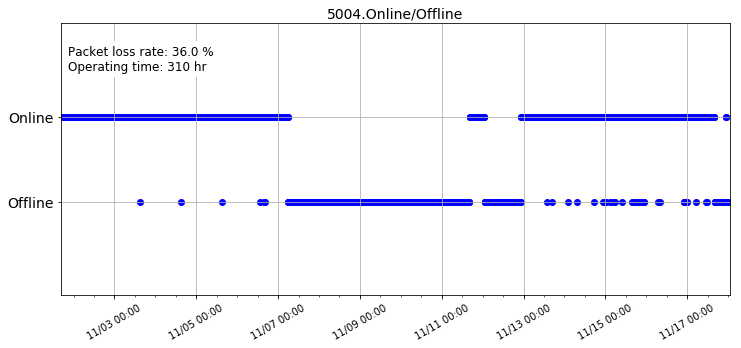

In [5]:
idNum = 5004
queryURL = creatURL(idNum, 201911)
queryStr = query_data(queryURL)
queryDf  = creat_df(queryStr)
dfPlot1  = insertNONE(queryDf, idNum)
dfPlot1  = setTimetRange('20191101173639', dfPlot1, 0)
plotSingleDia(dfPlot1, idNum)

ID numeber 5002 is done!
2019-10-25 16:31:08    False
2019-10-25 16:41:31    False
2019-10-25 16:51:54     True
2019-10-25 17:01:38    False
2019-10-25 17:11:59    False
Name: 7, dtype: bool
-----------------------------
2019-10-30 16:37:06    True
2019-10-30 16:47:26    True
2019-10-30 16:57:46    True
2019-10-30 17:08:06    True
2019-10-30 17:18:26    True
Name: 7, dtype: bool
-----------------------------


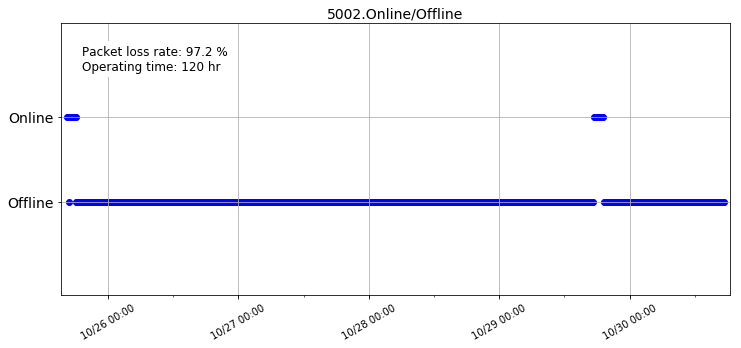

In [30]:
idNum = 5002
df1 = csv_read("exp2_rawData\INCM01_5002_20191025162059.csv",idNum)
df1 = df1[7].isna()
df1  = setTimetRange('20191025162059', df1, 5.04)
plotSingleDia(df1, idNum)

ID numeber 5002 is done!
2019-09-22 21:34:24    False
2019-09-22 21:44:33    False
2019-09-22 21:54:52    False
2019-09-22 22:05:11    False
2019-09-22 22:15:30    False
Name: 7, dtype: bool
-----------------------------
2019-09-27 21:42:45    False
2019-09-27 21:53:05    False
2019-09-27 22:03:01    False
2019-09-27 22:13:20    False
2019-09-27 22:23:15    False
Name: 7, dtype: bool
-----------------------------


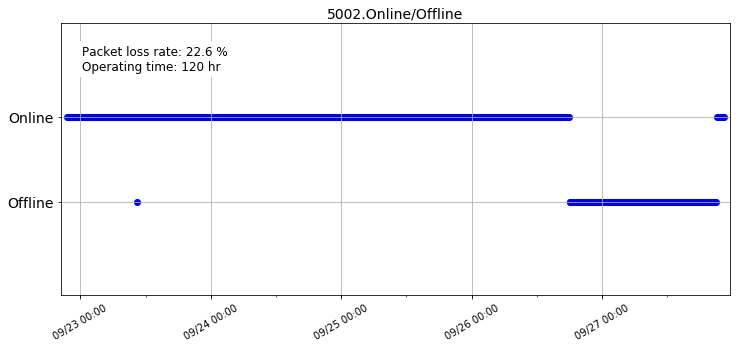

In [33]:
idNum = 5002
df1 = csv_read("exp0_rawData\INCM01_5002_20190922213424.csv",idNum)
df1 = df1[7].isna()
df1  = setTimetRange('20190922213424', df1, 5.04)
plotSingleDia(df1, idNum)

ID numeber 5002 is done!
2019-10-17 17:16:23    False
2019-10-17 17:26:32    False
2019-10-17 17:36:52    False
2019-10-17 17:47:09    False
2019-10-17 17:57:24    False
Name: 7, dtype: bool
-----------------------------
2019-10-22 17:30:51    True
2019-10-22 17:41:17    True
2019-10-22 17:51:43    True
2019-10-22 18:02:09    True
2019-10-22 18:12:35    True
Name: 7, dtype: bool
-----------------------------


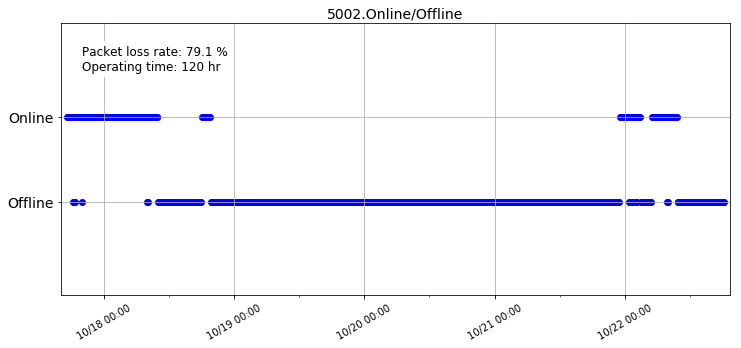

In [28]:
idNum = 5002
df1 = csv_read("exp1_rawData\INCM01_5002_20191014125339.csv",idNum)
df1 = df1[7].isna()
df1  = setTimetRange('20191017171623', df1, 5.04)
plotSingleDia(df1, idNum)

In [31]:
idNum = 5002
queryURL = creatURL(idNum, 201909)
queryStr = query_data(queryURL)
queryDf  = creat_df(queryStr)
if queryDf.empty:
    print("No data")
else:
    dfPlot1  = insertNONE(queryDf, idNum)
    dfPlot1  = setTimetRange('20190924000000', dfPlot1, 5.04)
    plotSingleDia(dfPlot1, idNum)

No data


In [ ]:
packetLossRate = inputDF.sum()/inputDF.count()
packetLossRate = round(packetLossRate,4) * 100

In [ ]:
idNum = 5004
queryURL = creatURL(idNum, 201911)
queryStr = query_data(queryURL)
queryDf  = creat_df(queryStr)
dfPlot1  = insertNONE(queryDf, idNum)
dfPlot1  = setTimetRange('20191101173639', dfPlot1)
plotSingleDia(dfPlot1, idNum)




fig = plt.figure(num=1, figsize=[12,10])
plt.subplot(2, 1, 1)
ax1 = plt.subplot(211)
ax1.set_title(str(idNum1) +'.Online/Offline', fontdict = {'fontsize':14})
for ii in range(0,len(dfPlot1)):
    if dfPlot1[ii]:
        #print("It is a NAN value.")
        plt.scatter(dfPlot1.index[ii],0, c ='b')
    else:
        #print("It is not a NAN value.")
        plt.scatter(dfPlot1.index[ii],1, c ='b')       

packetLossRate = df1[df1.columns[-1]].isna().sum()/(df1[df1.columns[0]].count())
packetLossRate = round(packetLossRate,4) * 100
ax1.text(dfPlot1.index[0] - timedelta(days = 0.8),1.55,
         "Packet loss rate: {:.3} %".format(packetLossRate), 
         fontsize = 12, 
         bbox=dict(facecolor="white", alpha = 1, edgecolor = "none" ))

plt.ylim(-1.1, 2.1)
#plt.yticks(np.arange(0, 1.1, step = 1))
plt.yticks(np.arange(2), ('Offline', 'Online'))
#minorLocator = MultipleLocator(0.5)
#ax1.xaxis.set_minor_locator(minorLocator)
plt.xticks(rotation = 0)
ax1.grid()
#ax1.set_xticklabels([])


plt.subplot(2, 1, 2)
ax2 = plt.subplot(212, sharex = ax1)
ax2.set_title(str(idNum2) +'.Online/Offline', fontdict = {'fontsize':14})
for ii in range(0,len(dfPlot2)):
    if dfPlot2[ii]:
        #print("It is a NAN value.")
        plt.scatter(dfPlot2.index[ii],0, c ='b')
    else:
        #print("It is not a NAN value.")
        plt.scatter(dfPlot2.index[ii],1, c ='b')       

packetLossRate = df2[df2.columns[-1]].isna().sum()/(df2[df2.columns[0]].count())
packetLossRate = round(packetLossRate,4) * 100
ax2.text(dfPlot2.index[0] - timedelta(days = 0.8),1.55,
         "Packet loss rate: {:.3} %".format(packetLossRate), 
         fontsize = 12, 
         bbox=dict(facecolor="white", alpha = 1, edgecolor = "none" ))

plt.ylim(-1.1, 2.1)
#plt.yticks(np.arange(0, 1.1, step = 1))
plt.yticks(np.arange(2), ('Offline', 'Online'))
minorLocator = MultipleLocator(0.5)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.grid()
plt.xticks(rotation = 0)
ax2.set_xlim(dfPlot2.index[0] - timedelta(days = 1), dfPlot2.index[-1] + timedelta(days = 1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))



now = strftime("%Y%m%d%H%M%S")
fig.savefig('packetLoss_ana_' + str(idNum1) + '_' + str(idNum2) + '_' + now +'.jpg', dpi= 400)